## MODELLING AND EVALUATION

 Goal: To build a practical **offline recommender** that generates high-quality top-K suggestions using a multi-method candidate pool and simple business-aware re-ranking. We evaluate with standard ranking metrics on a **time-ordered split** to mimic production.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.sparse import coo_matrix, csr_matrix, diags
from scipy.sparse.linalg import svds
from collections import defaultdict

In [ ]:
# 1) Imports & Config

# --- global config ---
K = 10                         # top-K for evaluation
EVENT_WEIGHTS = {'view': 1.0, 'addtocart': 3.0, 'transaction': 5.0}
MIN_TRAIN_INTERACTIONS = 2     # drop ultra-sparse train users
CHUNK_USERS = 25000            # evaluation in chunks to avoid long single loops
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


df = pd.read_csv("../Data/Cleaned Dataset/final_merged_events.csv")

# Ensure timestamp as datetime (use event_time if you prefer)
if 'event_time' in df.columns:
    df['event_time'] = pd.to_datetime(df['event_time'], errors='coerce')
    df['ts_dt'] = df['event_time']
else:
    df['ts_dt'] = pd.to_datetime(df['timestamp'], unit='ms', errors='coerce')

# Keep only needed cols
df = df[['visitorid','itemid','event','ts_dt']].dropna(subset=['visitorid','itemid','event','ts_dt']).copy()

# =========================
# 2) Weighting & Train/Test Split (chronological leave-last-out)
# =========================
df['w'] = df['event'].map(EVENT_WEIGHTS).fillna(0.5)  # unseen events get small weight

# sort by time per user
df = df.sort_values(['visitorid','ts_dt'])

# last interaction per user -> test; others -> train
last_idx = df.groupby('visitorid')['ts_dt'].idxmax()
df['split'] = 'train'
df.loc[last_idx, 'split'] = 'test'

train = df[df['split']=='train'].copy()
test  = df[df['split']=='test'].copy()

# drop users with too few train interactions (optional, improves CF stability)
train_counts = train['visitorid'].value_counts()
keep_users = set(train_counts[train_counts >= MIN_TRAIN_INTERACTIONS].index)
train = train[train['visitorid'].isin(keep_users)]
test  = test[test['visitorid'].isin(keep_users)]


In [3]:

# =========================
# 3) Build ID Mappings & Sparse User–Item Matrix (train)
# =========================
unique_users = train['visitorid'].unique()
unique_items = train['itemid'].unique()

user2idx = {u:i for i,u in enumerate(unique_users)}
item2idx = {i:j for j,i in enumerate(unique_items)}
idx2user = np.array(unique_users)
idx2item = np.array(unique_items)

# remap train
tr_u = train['visitorid'].map(user2idx).values
tr_i = train['itemid'].map(item2idx).values
tr_w = train['w'].values

# sum duplicates by coo -> csr
X_train = coo_matrix((tr_w, (tr_u, tr_i)), shape=(len(unique_users), len(unique_items))).tocsr()

n_users, n_items = X_train.shape
print("Train matrix:", X_train.shape, "| nnz:", X_train.nnz)

# seen items per user (train)
seen_train = {}
X_train_csr = X_train.tocsr()
for u in range(n_users):
    start, end = X_train_csr.indptr[u], X_train_csr.indptr[u+1]
    seen_train[u] = set(X_train_csr.indices[start:end])

# test ground truth (only items that exist in train space)
test_truth = defaultdict(set)
test_mapped = test[test['itemid'].isin(item2idx)].copy()
for r in test_mapped.itertuples(index=False):
    u = r.visitorid
    i = r.itemid
    test_truth[u].add(i)

# restrict evaluation users to those present in train mapping and with >0 ground truth
eval_users = [u for u in test_truth.keys() if u in user2idx]
print("Eval users (with test truth & in-train):", len(eval_users))

Train matrix: (199983, 125261) | nnz: 722658
Eval users (with test truth & in-train): 190636


In [ ]:

# 4) Utility: Metrics

def recall_at_k(true_items, rec_list, k=10):
    if not true_items: return 0.0
    return len(set(rec_list[:k]) & set(true_items)) / len(true_items)

def ap_at_k(true_items, rec_list, k=10):
    if not true_items: return 0.0
    true = set(true_items)
    hits, ap = 0, 0.0
    for i, it in enumerate(rec_list[:k], start=1):
        if it in true:
            hits += 1
            ap += hits / i
    return ap / min(len(true_items), k)

def ndcg_at_k(true_items, rec_list, k=10):
    if not true_items: return 0.0
    true = set(true_items)
    dcg = 0.0
    for i, it in enumerate(rec_list[:k], start=1):
        if it in true:
            dcg += 1.0 / np.log2(i+1)
    ideal = min(len(true_items), k)
    idcg = sum(1.0 / np.log2(i+1) for i in range(1, ideal+1))
    return dcg / idcg if idcg > 0 else 0.0

In [5]:
# =========================
# 5) Popularity Baseline
# =========================
# global top items by train weight (heavier weight => more important)
item_pop = np.asarray(X_train.sum(axis=0)).ravel()
pop_order = np.argsort(-item_pop)  # item indices (train-space)

def toplist_pop(u_idx, k=K):
    # same list for all users (filter seen to avoid duplicates)
    seen = seen_train.get(u_idx, set())
    out = []
    for j in pop_order:
        if j not in seen:
            out.append(j)
            if len(out) == k: break
    return [idx2item[j] for j in out]

In [6]:

# =========================
# 6) Weightings: TF-IDF & BM25
# =========================
def tfidf_weight(X):
    """ Right-multiply by IDF on items (columns). """
    # df_i: number of users who interacted with item i
    df_i = np.diff(X.tocsc().indptr)  # fast column nnz
    idf = np.log((X.shape[0] + 1) / (df_i + 1)) + 1.0
    W = diags(idf)
    return (X @ W).tocsr()

def bm25_weight(X, K1=100, B=0.8):
    """
    BM25 for implicit feedback treating each user-row as a document.
    """
    X = X.tocsr().astype(np.float64)
    # document lengths per user
    row_sums = np.asarray(X.sum(axis=1)).ravel()
    avg_len = row_sums.mean() + 1e-9

    # df per item
    df_i = np.diff(X.tocsc().indptr).astype(np.float64)
    idf = np.log((X.shape[0] - df_i + 0.5) / (df_i + 0.5))
    idf = np.maximum(idf, 0)  # clamp negatives

    X_bm25 = X.copy().tocoo()
    # term frequency (here: weights) with BM25 saturation
    norm = K1 * (1 - B + B * (row_sums[X_bm25.row] / avg_len))
    X_bm25.data = (X_bm25.data * (K1 + 1)) / (X_bm25.data + norm)
    # apply idf
    X_bm25.data *= idf[X_bm25.col]
    return X_bm25.tocsr()

# Precompute variants
X_RAW   = X_train
X_TFIDF = tfidf_weight(X_train)
X_BM25  = bm25_weight(X_train)

In [7]:
# =========================
# 7) Item–Item Cosine (memory-safe, no full similarity)
#    scores = (w * C^T) * C, where C = column-L2-normalized X
# =========================
def prepare_itemcosine_inputs(X):
    # column norms
    col_sq = np.ravel(X.power(2).sum(axis=0))
    col_norm = np.sqrt(col_sq) + 1e-12
    inv = 1.0 / col_norm
    C = (X @ diags(inv)).tocsr()  # users x items, col-normalized
    return C, inv  # inv kept just in case

def recommend_itemcosine(u_idx, X, C, k=K):
    """Recommend via item–item cosine using two-step multiplication (sparse-safe)."""
    seen = seen_train.get(u_idx, set())
    # w = user row over items
    w = X[u_idx, :]                      # 1 x n_items
    # y = w * C^T  -> shape (1, n_users)
    y = (w @ C.T)                        # sparse * sparse -> sparse
    # scores = y * C -> shape (1, n_items)
    s = (y @ C).toarray().ravel()        # dense 1D
    if seen:
        s[list(seen)] = -np.inf
    # top-k
    top = np.argpartition(-s, k)[:k]
    top = top[np.argsort(-s[top])]
    return [idx2item[j] for j in top]

# prepare cosine inputs for each weighting
C_RAW,   _ = prepare_itemcosine_inputs(X_RAW)
C_TFIDF, _ = prepare_itemcosine_inputs(X_TFIDF)
C_BM25,  _ = prepare_itemcosine_inputs(X_BM25)

# wrappers
def toplist_itemcosine_raw(u_idx, k=K):   return recommend_itemcosine(u_idx, X_RAW,   C_RAW,   k)
def toplist_itemcosine_tfidf(u_idx, k=K): return recommend_itemcosine(u_idx, X_TFIDF, C_TFIDF, k)
def toplist_itemcosine_bm25(u_idx, k=K):  return recommend_itemcosine(u_idx, X_BM25,  C_BM25,  k)

In [8]:
 
# 8) SVD Latent Factors (pure SciPy)
#    X ≈ U S V^T; use P = U sqrt(S), Q = V sqrt(S) for scoring: score = P[u]·Q^T

def train_svd(X, factors=64, random_state=RANDOM_STATE):
    U, s, Vt = svds(X.asfptype(), k=factors, which='LM', return_singular_vectors=True)
    # sort largest -> smallest
    order = np.argsort(-s)
    s = s[order]
    U = U[:, order]
    Vt = Vt[order, :]
    Ssqrt = np.sqrt(s)
    P = U * Ssqrt   # users x k
    Q = (Vt.T * Ssqrt)  # items x k
    # L2 normalize rows (optional, often helps)
    Pu = np.linalg.norm(P, axis=1, keepdims=True) + 1e-12
    Qi = np.linalg.norm(Q, axis=1, keepdims=True) + 1e-12
    return (P / Pu), (Q / Qi)

def recommend_svd(u_idx, P, Q, k=K):
    seen = seen_train.get(u_idx, set())
    scores = (P[u_idx, :] @ Q.T)   # 1 x n_items
    if seen:
        scores[list(seen)] = -np.inf
    top = np.argpartition(-scores, k)[:k]
    top = top[np.argsort(-scores[top])]
    return [idx2item[j] for j in top]

# Train SVD on the strongest weighting (BM25 usually best)
P_bm25, Q_bm25 = train_svd(X_BM25, factors=64)
def toplist_svd_bm25(u_idx, k=K): return recommend_svd(u_idx, P_bm25, Q_bm25, k)

In [9]:
import numpy as np
import pandas as pd

# -------- helpers: masking & topk extraction (batched) --------
def _mask_seen_rows(scores, batch_user_idx, seen_train, neg_val=-np.inf):
    """Set scores of seen items to -inf for each user row."""
    for r, u_idx in enumerate(batch_user_idx):
        s = seen_train.get(u_idx, None)
        if s:
            scores[r, list(s)] = neg_val

def _rowwise_topk_indices(scores, k):
    """
    For a 2D array (n_rows x n_items), return per-row top-k item indices (by column index).
    Uses argpartition -> arg sort on the k-slice for speed.
    """
    # argpartition gives unordered top-k positions
    part = np.argpartition(-scores, kth=k-1, axis=1)[:, :k]
    # order those k positions properly per row
    row_idx = np.arange(scores.shape[0])[:, None]
    part_scores = scores[row_idx, part]
    order = np.argsort(-part_scores, axis=1)
    return part[row_idx, order]

# -------- batched recommenders (no per-user Python loops) --------
def batch_toplist_pop(batch_user_idx, pop_order, k):
    """
    Popularity baseline; same list for everyone, but we filter seen items user-wise.
    We’ll opportunistically scan a bit more than k to avoid many re-scans.
    """
    k_probe = min(len(pop_order), k + 200)  # small headroom to compensate for seen filtering
    head = pop_order[:k_probe]
    out = []
    for u_idx in batch_user_idx:
        seen = seen_train.get(u_idx, set())
        rec = [idx2item[j] for j in head if j not in seen]
        if len(rec) < k:
            # fallback: extend scan if needed
            for j in pop_order[k_probe:]:
                if j not in seen:
                    rec.append(idx2item[j])
                    if len(rec) == k:
                        break
        out.append(rec[:k])
    return out

def batch_toplist_itemcosine(batch_user_idx, X_base, C, k):
    """
    Item–item cosine in batch:
      scores = (W @ C^T) @ C, where W = X_base[batch, :]
    """
    W = X_base[batch_user_idx, :]               # (B x n_items) sparse
    Y = (W @ C.T)                               # (B x n_users) sparse
    S = (Y @ C).toarray()                       # (B x n_items) dense
    _mask_seen_rows(S, batch_user_idx, seen_train, neg_val=-np.inf)
    topk_cols = _rowwise_topk_indices(S, k)     # (B x k) item indices (train space)
    return [[idx2item[j] for j in row] for row in topk_cols]

def batch_toplist_svd(batch_user_idx, P, Q, k):
    """
    SVD scoring: scores = P_batch @ Q^T (dense x dense)
    """
    P_batch = P[batch_user_idx, :]              # (B x f)
    S = P_batch @ Q.T                           # (B x n_items)
    _mask_seen_rows(S, batch_user_idx, seen_train, neg_val=-np.inf)
    topk_cols = _rowwise_topk_indices(S, k)
    return [[idx2item[j] for j in row] for row in topk_cols]

# -------- metrics (same as before) --------
def recall_at_k(true_items, rec_list, k=10):
    if not true_items: return 0.0
    return len(set(rec_list[:k]) & set(true_items)) / len(true_items)

def ap_at_k(true_items, rec_list, k=10):
    if not true_items: return 0.0
    true = set(true_items)
    hits, ap = 0, 0.0
    for i, it in enumerate(rec_list[:k], start=1):
        if it in true:
            hits += 1
            ap += hits / i
    return ap / min(len(true_items), k)

def ndcg_at_k(true_items, rec_list, k=10):
    if not true_items: return 0.0
    true = set(true_items)
    dcg = 0.0
    for i, it in enumerate(rec_list[:k], start=1):
        if it in true:
            dcg += 1.0 / np.log2(i+1)
    ideal = min(len(true_items), k)
    idcg = sum(1.0 / np.log2(i+1) for i in range(1, ideal+1))
    return dcg / idcg if idcg > 0 else 0.0

# -------- batched evaluator (all users, but processed in chunks) --------
def eval_batched(model_name, batch_func, k=K, batch_size=20000, verbose=True):
    users_eval = np.array([u for u in eval_users if u in user2idx])
    n = len(users_eval)
    recalls, maps, ndcgs = [], [], []
    done = 0

    for start in range(0, n, batch_size):
        batch_users_orig = users_eval[start:start+batch_size]
        batch_idx = np.array([user2idx[u] for u in batch_users_orig], dtype=int)

        # truth per user (in original item ids)
        truth_list = []
        keep_mask = []
        for u_orig in batch_users_orig:
            t = [it for it in test_truth[u_orig] if it in item2idx]  # keep items known to train
            truth_list.append(t)
            keep_mask.append(len(t) > 0)

        # filter out users with empty truth in this batch (saves scoring time)
        keep_mask = np.array(keep_mask, dtype=bool)
        if not keep_mask.any():
            done += len(batch_users_orig)
            if verbose: print(f"[{model_name}] {done}/{n} users (no truth in batch)")
            continue
        batch_users_orig = batch_users_orig[keep_mask]
        batch_idx = batch_idx[keep_mask]
        truth_list = [truth_list[i] for i in np.where(keep_mask)[0]]

        # get recommendations for this batch (list of lists of itemids)
        recs_batch = batch_func(batch_idx, k)

        # compute metrics
        for truth, rec in zip(truth_list, recs_batch):
            recalls.append(recall_at_k(truth, rec, k))
            maps.append(ap_at_k(truth, rec, k))
            ndcgs.append(ndcg_at_k(truth, rec, k))

        done += len(keep_mask)
        if verbose:
            print(f"[{model_name}] processed: {min(done,n)}/{n}")

    return {
        "label": model_name,
        "users": len(recalls),
        "recall": np.mean(recalls) if recalls else 0.0,
        "map":    np.mean(maps)    if maps    else 0.0,
        "ndcg":   np.mean(ndcgs)   if ndcgs   else 0.0,
    }

# -------- run models (batched) --------
rows = []

# Popularity (precomputed order from earlier cell)
rows.append(eval_batched(
    "Popularity@10",
    batch_func=lambda batch_idx, k=K: batch_toplist_pop(batch_idx, pop_order, k),
    k=K, batch_size=2000, verbose=True
))

# Item–Item cosine (RAW / TF-IDF / BM25)
rows.append(eval_batched(
    "ItemCosine-RAW@10",
    batch_func=lambda batch_idx, k=K: batch_toplist_itemcosine(batch_idx, X_RAW,   C_RAW,   k),
    k=K, batch_size=500, verbose=True   # item-cosine is heavier; smaller batch helps memory
))
rows.append(eval_batched(
    "ItemCosine-TFIDF@10",
    batch_func=lambda batch_idx, k=K: batch_toplist_itemcosine(batch_idx, X_TFIDF, C_TFIDF, k),
    k=K, batch_size=500, verbose=True
))
rows.append(eval_batched(
    "ItemCosine-BM25@10",
    batch_func=lambda batch_idx, k=K: batch_toplist_itemcosine(batch_idx, X_BM25,  C_BM25,  k),
    k=K, batch_size=500, verbose=True
))

# SVD on BM25
rows.append(eval_batched(
    "SVD-BM25@10",
    batch_func=lambda batch_idx, k=K: batch_toplist_svd(batch_idx, P_bm25, Q_bm25, k),
    k=K, batch_size=1500, verbose=True
))

eval_df = pd.DataFrame(rows)
eval_df


[Popularity@10] processed: 2000/190636
[Popularity@10] processed: 4000/190636
[Popularity@10] processed: 6000/190636
[Popularity@10] processed: 8000/190636
[Popularity@10] processed: 10000/190636
[Popularity@10] processed: 12000/190636
[Popularity@10] processed: 14000/190636
[Popularity@10] processed: 16000/190636
[Popularity@10] processed: 18000/190636
[Popularity@10] processed: 20000/190636
[Popularity@10] processed: 22000/190636
[Popularity@10] processed: 24000/190636
[Popularity@10] processed: 26000/190636
[Popularity@10] processed: 28000/190636
[Popularity@10] processed: 30000/190636
[Popularity@10] processed: 32000/190636
[Popularity@10] processed: 34000/190636
[Popularity@10] processed: 36000/190636
[Popularity@10] processed: 38000/190636
[Popularity@10] processed: 40000/190636
[Popularity@10] processed: 42000/190636
[Popularity@10] processed: 44000/190636
[Popularity@10] processed: 46000/190636
[Popularity@10] processed: 48000/190636
[Popularity@10] processed: 50000/190636
[Pop

,label,users,recall,map,ndcg
0,Popularity@10,190636,0.001673,0.000469,0.000742
1,ItemCosine-RAW@10,190636,0.035229,0.015882,0.020419
2,ItemCosine-TFIDF@10,190636,0.035476,0.015988,0.020558
3,ItemCosine-BM25@10,190636,0.077498,0.030939,0.041785
4,SVD-BM25@10,190636,0.008262,0.003269,0.004429


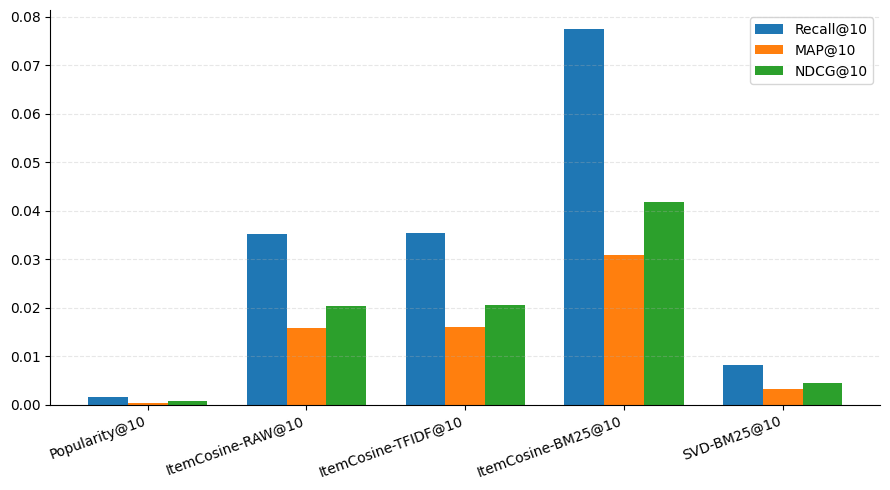

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(9,5))
x = np.arange(len(eval_df))
w = 0.25
ax.bar(x - w, eval_df['recall'],   width=w, label='Recall@10')
ax.bar(x,       eval_df['map'],     width=w, label='MAP@10')
ax.bar(x + w,   eval_df['ndcg'],    width=w, label='NDCG@10')
ax.set_xticks(x)
ax.set_xticklabels(eval_df['label'], rotation=20, ha='right')
ax.grid(axis='y', linestyle='--', alpha=0.3)
for spine in ('top','right'): ax.spines[spine].set_visible(False)
ax.legend()
plt.tight_layout()
plt.show()


In [11]:
import gc
import math
import numpy as np
import pandas as pd
from collections import defaultdict, Counter

from scipy.sparse import coo_matrix, csr_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# ========= KNOBS (tune for speed vs quality) ========= #
K = 10                       # top-K for evaluation
EVENT_WEIGHTS = {'view': 1.0, 'addtocart': 5.0, 'transaction': 20.0}
HALF_LIFE_DAYS = 21         # recency half-life for decay
BM25_K1 = 1.2               # BM25 parameters
BM25_B  = 0.75

CAND_BM25 = 200             # #candidates from BM25 per user
CAND_COVIS = 100            # #candidates from co-vis per user
CAND_POP = 100              # #candidates from popularity per user
MAX_CANDS_PER_USER = 400

# co-vis session/window parameters
SESSION_GAP_MIN = 30
COVIS_WINDOW = 5            # consider +/- this many neighbors in a session
TOP_COVIS_PER_ITEM = 50     # store top-N neighbors per item in co-vis table

# evaluation chunking
EVAL_CHUNK_USERS = 20_000

# ===================================================== #


In [12]:
# Ensure types
df = pd.read_csv("../Data/Cleaned Dataset/final_merged_events.csv")
df = df.copy()
df['event_time'] = pd.to_datetime(df['event_time'])
df = df.sort_values('event_time')

# Keep only events we care about
df = df[df['event'].isin(['view', 'addtocart', 'transaction'])]

# Add date for temporal splits & recency
df['date'] = df['event_time'].dt.date
df['ts'] = df['event_time'].astype('int64') // 10**9  # seconds


In [13]:
times = df['event_time'].sort_values()
t80 = times.quantile(0.8)
t90_train = times[times <= t80].quantile(0.9)

df_train_full = df[df['event_time'] <= t80]
df_val = df_train_full[df_train_full['event_time'] > t90_train]
df_train = df_train_full[df_train_full['event_time'] <= t90_train]
df_test  = df[df['event_time'] > t80]

print("Train:", df_train['event_time'].min(), "→", df_train['event_time'].max(), len(df_train))
print("Val  :", df_val['event_time'].min(),   "→", df_val['event_time'].max(),   len(df_val))
print("Test :", df_test['event_time'].min(),  "→", df_test['event_time'].max(),  len(df_test))


Train: 2015-05-03 03:00:04.384000 → 2015-08-05 18:04:34.556000 1984060
Val  : 2015-08-05 18:04:38.117000 → 2015-08-18 04:23:01.129000 220452
Test : 2015-08-18 04:23:20.445000 → 2015-09-18 02:59:47.788000 551129


In [14]:
# Recency decay weights
def recency_decay(ts_series, ref_ts, half_life_days=HALF_LIFE_DAYS):
    hl_seconds = half_life_days * 24 * 3600
    dt = (ref_ts - ts_series).clip(lower=0)
    return np.exp(-np.log(2) * dt / hl_seconds)

# reference time = end of train
ref_ts = int(df_train['ts'].max())

def make_weighted_interactions(df_part):
    base = df_part['event'].map(EVENT_WEIGHTS).astype(float)
    decay = recency_decay(df_part['ts'], ref_ts)
    return base * decay

df_train = df_train.copy()
df_train['w'] = make_weighted_interactions(df_train)

# Build user & item index maps from TRAIN ONLY
unique_users = df_train['visitorid'].unique()
unique_items = df_train['itemid'].unique()
user2idx = {u:i for i,u in enumerate(unique_users)}
item2idx = {it:j for j,it in enumerate(unique_items)}

# Sparse matrix (users x items) from train
rows = df_train['visitorid'].map(user2idx).values
cols = df_train['itemid'].map(item2idx).values
data = df_train['w'].values
X_train_raw = coo_matrix((data, (rows, cols)),
                         shape=(len(unique_users), len(unique_items))).tocsr()

# BM25 weighting on users x items
def bm25_weight(X, K1=BM25_K1, B=BM25_B):
    # X is csr (users x items)
    # BM25 per item (column) using per-user lengths
    X = X.tocoo()
    n_users, n_items = X.shape
    # doc length = per-user nnz sum
    user_len = np.asarray(X.sum(axis=1)).ravel()
    avg_len = user_len.mean() if n_users > 0 else 1.0

    # idf per item
    # df_j = number of users who interacted with item j
    df_items = np.diff(X.tocsc().indptr)  # length = n_items
    idf = np.log((n_users - df_items + 0.5) / (df_items + 0.5)).clip(min=0)

    # BM25 transform each non-zero x_ij
    # w_ij = idf_j * (x_ij*(K1+1)) / (x_ij + K1*(1 - B + B*len_i/avg_len))
    x = X.data
    i = X.row
    j = X.col
    denom = x + K1 * (1.0 - B + B * (user_len[i] / (avg_len + 1e-9)))
    w = idf[j] * (x * (K1 + 1.0)) / (denom + 1e-9)
    X_bm25 = coo_matrix((w, (i, j)), shape=X.shape).tocsr()
    return X_bm25

X_train_bm25 = bm25_weight(X_train_raw)

# L2-normalize item columns for cosine scoring
def l2_normalize_columns(X):
    Xc = X.tocsc(copy=True)
    norms = np.sqrt(np.asarray(Xc.power(2).sum(axis=0)).ravel()) + 1e-12
    Xc.data /= norms[Xc.indices]  # careful: indices on CSC are row indices
    return Xc.tocsr()

from sklearn.preprocessing import normalize
X_cols_norm = normalize(X_train_bm25, norm='l2', axis=0, copy=True)



In [15]:
# Popularity (weighted) from train
pop_item_counts = (
    df_train.groupby('itemid')['w'].sum().sort_values(ascending=False)
)
popular_items_idx = [item2idx[it] for it in pop_item_counts.index if it in item2idx]

# ---- Co-visitation (session-level) ----
def build_covis(df_part, session_gap_min=SESSION_GAP_MIN, window=COVIS_WINDOW, topN=TOP_COVIS_PER_ITEM):
    # work on views+addtocart+transaction (optionally views only)
    d = df_part[['visitorid','itemid','event_time']].copy()
    d = d.sort_values(['visitorid','event_time'])
    # sessionize per user
    d['prev_time'] = d.groupby('visitorid')['event_time'].shift(1)
    gap = (d['event_time'] - d['prev_time']).dt.total_seconds().fillna(0)
    d['session_id'] = (gap > session_gap_min*60).groupby(d['visitorid']).cumsum()

    covis = defaultdict(Counter)
    for (uid, sid), g in d.groupby(['visitorid','session_id'], sort=False):
        items = g['itemid'].tolist()
        n = len(items)
        # sliding window pairs
        for p in range(n):
            a = items[p]
            start = max(0, p - window)
            end   = min(n, p + window + 1)
            for q in range(start, end):
                if q == p: 
                    continue
                b = items[q]
                covis[a][b] += 1
    # keep top neighbors
    covis_top = {}
    for a, ctr in covis.items():
        covis_top[a] = [b for b,_ in ctr.most_common(topN)]
    return covis_top

covis_neighbors = build_covis(df_train)



In [16]:
# Helper: get seen items per user (from train)
seen_by_user = defaultdict(set)
for u, it in zip(df_train['visitorid'].map(user2idx, na_action='ignore'),
                 df_train['itemid'].map(item2idx, na_action='ignore')):
    if pd.isna(u) or pd.isna(it): 
        continue
    seen_by_user[int(u)].add(int(it))

def bm25_candidates_for_user(u_idx, topn=CAND_BM25):
    # user profile row (1 x n_items)
    u_row = X_train_bm25[u_idx, :]
    scores = u_row.dot(X_cols_norm).toarray().ravel()
    # remove seen
    if seen_by_user.get(u_idx):
        scores[list(seen_by_user[u_idx])] = -1e12
    idx = np.argpartition(-scores, kth=min(topn, len(scores)-1))[:topn]
    idx = idx[np.argsort(-scores[idx])]
    return idx, scores[idx]

def covis_candidates_for_user(u_idx, topn=CAND_COVIS):
    # take most recent items for that user in train
    uid = unique_users[u_idx]
    last_items = (
        df_train[df_train['visitorid']==uid]
        .sort_values('event_time')
        .tail(20)['itemid'].tolist()
    )
    cand = []
    for it in reversed(last_items):
        neighbors = covis_neighbors.get(it, [])
        cand.extend(neighbors)
        if len(cand) >= topn*2:  # oversample; will de-dup later
            break
    cand = [item2idx[it] for it in cand if it in item2idx]
    # remove seen + keep topn by frequency approximation
    cand = [c for c in cand if c not in seen_by_user.get(u_idx, set())]
    # simple frequency sort
    fre = Counter(cand)
    top = [c for c,_ in fre.most_common(topn)]
    # fake scores = frequency
    sc = np.array([fre[c] for c in top], dtype=float)
    return np.array(top, dtype=int), sc

def pop_candidates_for_user(u_idx, topn=CAND_POP):
    # remove seen
    seen = seen_by_user.get(u_idx, set())
    out = [j for j in popular_items_idx if j not in seen][:topn]
    sc  = np.arange(len(out), 0, -1, dtype=float)  # simple descending score
    return np.array(out, dtype=int), sc


In [18]:
# ==== FAST PRECOMPUTE OF SIGNALS (vectorized, memory-aware) ====
# expects: df_train with columns ['visitorid','itemid','event','event_time','w','categoryid']
#          unique_items (array-like of item ids), unique_users (array-like of user ids)

import numpy as np
import pandas as pd

# Make sure types are friendly
df_train = df_train.copy()
df_train['event'] = df_train['event'].astype('category')
# keep categoryid as float if you have NaNs; we'll encode to integer codes below

# Ensure indexers
unique_items = pd.Index(unique_items)
unique_users = pd.Index(unique_users)

# 1) Item popularity (sum of weights) — aligned to all unique_items
item_pop_train = (
    df_train.groupby('itemid', observed=True)['w']
    .sum()
    .reindex(unique_items, fill_value=0.0)
    .astype('float32')
)

# 2) Item freshness (recency in days) — aligned to all unique_items
last_seen = (
    df_train.groupby('itemid', observed=True)['event_time']
    .max()
    .reindex(unique_items)
)
age_days = (df_train['event_time'].max() - last_seen).dt.days.fillna(999).astype('float32')
item_freshness = (1.0 / (1.0 + age_days)).astype('float32')  # 0..1, newer → larger

# 3) Category conversion rate (smoothed)
train_views = (
    df_train.loc[df_train['event'].eq('view')]
    .groupby('categoryid', observed=True)['itemid']
    .count()
)
train_txn = (
    df_train.loc[df_train['event'].eq('transaction')]
    .groupby('categoryid', observed=True)['itemid']
    .count()
)
conv_cat = ((train_txn.add(20, fill_value=0) / train_views.add(100, fill_value=0))).astype('float32')  # Laplace smoothing

# 4) Item → category (take the last category seen per item, vectorized)
#    Sort once, take groupby-last (fast & avoids Python loops)
item_cat = (
    df_train[['itemid','categoryid','event_time']]
    .sort_values(['itemid','event_time'])
    .groupby('itemid', observed=True)['categoryid']
    .last()
    .reindex(unique_items)
)

# 5) User–category affinity = share of user’s weighted interactions in each category (vectorized)
sum_uc = df_train.groupby(['visitorid','categoryid'], observed=True)['w'].sum()
user_cat = (sum_uc / sum_uc.groupby(level=0).transform('sum')).astype('float32')
# If you need a plain dict for quick lookups:
user_cat_dict = user_cat.to_dict()  # keys: (visitorid, categoryid) → float in [0,1]

# ---- Build arrays for constant-time lookups by item index ----

# Encode item categories as integer codes for array indexing
item_cat_c = pd.Categorical(item_cat)  # categories are sorted unique non-NaN category IDs
cat_codes = item_cat_c.codes.astype('int32')        # -1 for NaN
cat_values = pd.Index(item_cat_c.categories)        # actual categoryid values

# Map conv rate to category-code space
conv_per_code = np.zeros(len(cat_values), dtype='float32')
if len(cat_values) > 0:
    conv_per_code = conv_cat.reindex(cat_values, fill_value=0.0).to_numpy(dtype='float32')

# Final per-item arrays (index by item_idx)
item_pop_arr    = item_pop_train.to_numpy(dtype='float32')
item_fresh_arr  = item_freshness.to_numpy(dtype='float32')
item_cat_code   = cat_codes                                   # -1 means "unknown"
item_conv_arr   = np.where(item_cat_code >= 0, conv_per_code[item_cat_code], 0.0).astype('float32')

# Optional: quick helpers that DO NOT touch df_train again
def get_item_meta_fast(item_idx: int):
    """
    Returns:
      cat_code (int), pop (float), fresh (float), conv_rate (float)
    """
    c = item_cat_code[item_idx]
    pop = float(item_pop_arr[item_idx])
    fresh = float(item_fresh_arr[item_idx])
    conv = float(item_conv_arr[item_idx])
    return c, pop, fresh, conv

def get_user_cat_affinity_fast(user_idx: int, cat_code: int):
    """
    cat_code is from item_cat_code. Returns 0.0 if unknown/no affinity.
    """
    if cat_code < 0:
        return 0.0
    # map back from user_idx → original visitorid, and cat_code → categoryid value
    uid = unique_users[user_idx]
    catid = cat_values[cat_code]
    return float(user_cat_dict.get((uid, catid), 0.0))


In [ ]:
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix, csr_matrix

# 0) Defaults (if not already set)

K = globals().get('K', 10)
CHUNK_USERS = globals().get('CHUNK_USERS', 20000)
CAND_K = globals().get('CAND_K', 200)

# Sanity: we expect df_train/df_test with columns at least ['visitorid','itemid','event','event_time']
assert {'visitorid','itemid','event'}.issubset(df_train.columns)
assert {'visitorid','itemid','event'}.issubset(df_test.columns)

# If event weights not present, make them
if 'w' not in df_train.columns:
    w_map = {'view': 1.0, 'addtocart': 3.0, 'transaction': 5.0}
    df_train = df_train.assign(w=df_train['event'].map(w_map).fillna(0.5))


# 1) Train-only mappings (critical)

users_train = np.unique(df_train['visitorid'].values)
items_train = np.unique(df_train['itemid'].values)

user2idx = {u: i for i, u in enumerate(users_train)}
item2idx = {it: j for j, it in enumerate(items_train)}

unique_users = users_train
unique_items = items_train


# 2) Build CSR interaction matrix (train)

row = df_train['visitorid'].map(user2idx).values
col = df_train['itemid'].map(item2idx).values
dat = df_train['w'].astype(float).values

n_users = len(unique_users)
n_items = len(unique_items)

X_train = coo_matrix((dat, (row, col)), shape=(n_users, n_items)).tocsr()
X_train.sum_duplicates()

# Seen items per user (for filtering)
from collections import defaultdict
seen_train = defaultdict(set)
for r, c in zip(row, col):
    seen_train[r].add(c)


# 3) Weighting & safe column L2-normalization

def tfidf_weight(X):
    # X: csr
    Xc = X.tocsc(copy=True)
    n_rows, n_cols = Xc.shape
    # document frequency (per column nnz)
    df_col = np.diff(Xc.indptr)
    idf = np.log((n_rows + 1) / (df_col + 1)) + 1.0  # smoothed idf
    # tf = log(1 + x)
    Xc.data = np.log1p(Xc.data)
    Xc.data *= np.repeat(idf, df_col)
    return Xc.tocsr()

def bm25_weight(X, K1=1.2, B=0.75):
    # Work in CSR for per-row length normalization
    X = X.tocsr(copy=True)
    n_rows, n_cols = X.shape

    # idf from column nnz
    Xc = X.tocsc()
    df_col = np.diff(Xc.indptr)
    idf = np.log((n_rows - df_col + 0.5) / (df_col + 0.5))
    idf[idf < 0] = 0.0

    # row lengths
    row_sums = np.asarray(X.sum(axis=1)).ravel()
    avgdl = row_sums.mean() + 1e-12
    denom_row = K1 * (1 - B + B * (row_sums / avgdl))

    # expand row indices per data entry
    row_ids = np.repeat(np.arange(n_rows), np.diff(X.indptr))
    col_ids = X.indices

    tf_prime = (X.data * (K1 + 1.0)) / (X.data + denom_row[row_ids] + 1e-12)
    X.data = tf_prime * idf[col_ids]
    return X

def l2_normalize_columns(X):
    # Normalize columns so that cosine(item_i, item_j) works
    Xc = X.tocsc(copy=True)
    col_norms = np.sqrt(Xc.power(2).sum(axis=0)).A1
    col_norms[col_norms == 0] = 1.0
    # repeat each column norm for the number of nonzeros in that column
    scale = np.repeat(col_norms, np.diff(Xc.indptr))
    Xc.data = Xc.data / scale
    return Xc.tocsr()

# Choose base matrix variant (BM25 typically best here)
X_BM25 = bm25_weight(X_train)
C_BM25 = l2_normalize_columns(X_BM25)  # same shape (users x items), cols L2-normalized


# 4) Base recommender & toplists (item-cosine via two sparse multiplies)

def recommend_itemcosine(u_idx, X, C, k=K):
    """
    X: users x items CSR (weighted interactions)
    C: users x items CSR with L2-normalized columns
    Predict scores = (X[u,:] @ C.T) @ C  (implicit item-item cosine)
    """
    if u_idx >= X.shape[0]:
        return [], []
    w = X[u_idx, :]        # 1 x n_items
    if w.nnz == 0:
        return [], []

    y = (w @ C.T)          # 1 x n_users
    scores = (y @ C).toarray().ravel()  # 1 x n_items -> dense row

    # filter seen
    for it in seen_train.get(u_idx, ()):
        scores[it] = -np.inf

    if k >= len(scores):
        top_idx = np.argsort(-scores)
    else:
        top_part = np.argpartition(-scores, k)[:k]
        top_idx = top_part[np.argsort(-scores[top_part])]
    return top_idx[:k].tolist(), scores[top_idx[:k]].tolist()

def toplist_itemcosine_bm25(u_idx, k=K):
    idx, _ = recommend_itemcosine(u_idx, X_BM25, C_BM25, k)
    return idx

# Popularity baseline toplist (train popularity)
item_pop_train = np.asarray(X_train.sum(axis=0)).ravel()
pop_rank = np.argsort(-item_pop_train)

def toplist_pop(u_idx, k=K):
    # filter seen for this user
    seen = seen_train.get(u_idx, set())
    if not seen:
        return pop_rank[:k].tolist()
    # walk down the popularity list skipping seen
    out = []
    for it in pop_rank:
        if it not in seen:
            out.append(it)
            if len(out) >= k:
                break
    return out


# 5) Test ground-truth (transactions) & eval users aligned to train space

test_txn = (
    df_test[df_test['event'] == 'transaction']
    .groupby('visitorid')['itemid'].apply(set).to_dict()
)
# users to evaluate: must exist in train mapping
eval_users = [u for u in df_test['visitorid'].unique() if u in user2idx]
test_truth = test_txn  # alias if your notebook expects this name


# 6) Metric helpers (idempotent re-def ok)

def recall_at_k(truth_set, rec_list, k):
    if not truth_set: return 0.0
    hit = len(set(rec_list[:k]) & set(truth_set))
    return hit / float(len(truth_set))

def ap_at_k(truth_set, rec_list, k):
    if not truth_set: return 0.0
    score = 0.0
    hit = 0
    for i, itm in enumerate(rec_list[:k], 1):
        if itm in truth_set:
            hit += 1
            score += hit / i
    return score / min(len(truth_set), k) if hit else 0.0

def ndcg_at_k(truth_set, rec_list, k):
    import math
    dcg = 0.0
    for i, itm in enumerate(rec_list[:k], 1):
        if itm in truth_set:
            dcg += 1.0 / math.log2(i + 1)
    ideal = 0.0
    m = min(len(truth_set), k)
    for i in range(1, m + 1):
        ideal += 1.0 / math.log2(i + 1)
    return dcg / ideal if ideal > 0 else 0.0


# 7) Reranker (unchanged; uses metadata you already calculated)

def rerank_with_metadata(user_idx, base_items, w_base, w_pop, w_fresh, w_conv, w_aff, rank_decay, k=K):
    base_items = np.array(base_items, dtype=np.int64)
    if base_items.size == 0: 
        return np.array([], dtype=np.int64)

    # base rank score
    rank_pos = np.arange(1, base_items.size + 1, dtype=np.float64)
    s_base = 1.0 / (rank_pos ** rank_decay)

    # fetch per-item metadata (must exist in your notebook: item_pop_train, item_freshness, conv_cat, user_cat, etc.)
    pop = np.array([item_pop_train[unique_items[it]] if unique_items[it] in item_pop_train.index else 0.0
                    for it in base_items], dtype=np.float64)
    fresh = np.array([item_freshness.get(unique_items[it], 0.0) for it in base_items], dtype=np.float64)

    # category & conv rate
    cats = []
    for it in base_items:
        it_orig = unique_items[it]
        cat_vals = df_train.loc[df_train['itemid'].eq(it_orig), 'categoryid'].tail(1).values
        cats.append(cat_vals[0] if len(cat_vals) else np.nan)
    cats = np.array(cats)
    conv = np.array([float(conv_cat.get(c, 0.0)) if pd.notna(c) else 0.0 for c in cats], dtype=np.float64)

    # user affinity to category
    uid_orig = unique_users[user_idx]
    def user_cat_aff(c):
        if pd.isna(c): return 0.0
        return float(user_cat.get((uid_orig, c), 0.0))
    aff = np.array([user_cat_aff(c) for c in cats], dtype=np.float64)

    # combine
    s = (w_base * s_base) + (w_pop * pop) + (w_fresh * fresh) + (w_conv * conv) + (w_aff * aff)
    order = np.argsort(-s)
    return base_items[order][:k]


# 8) Eval wrapper (baseline vs. hybrid)

def eval_hybrid(weights, label, users_eval=None, chunk_size=CHUNK_USERS, k=K, cand_k=CAND_K):
    """
    weights None => 'no-rerank' baseline using toplist_itemcosine_bm25(u,k)
    """
    if users_eval is None:
        users_eval = [u for u in eval_users if u in user2idx]

    recalls, maps, ndcgs = [], [], []
    n_users = len(users_eval)

    for start in range(0, n_users, chunk_size):
        batch = users_eval[start:start+chunk_size]
        for u_orig in batch:
            u_idx = user2idx[u_orig]

            truth_items = test_truth.get(u_orig, set())
            truth_idx = { item2idx[it] for it in truth_items if it in item2idx }
            if not truth_idx:
                continue

            if weights is None:
                rec_idx = toplist_itemcosine_bm25(u_idx, k)
            else:
                w_base, w_pop, w_fresh, w_conv, w_aff, rd = weights
                base_idx = toplist_itemcosine_bm25(u_idx, cand_k)
                if not base_idx:
                    continue
                rec_idx = rerank_with_metadata(
                    user_idx=u_idx,
                    base_items=base_idx,
                    w_base=w_base, w_pop=w_pop, w_fresh=w_fresh, w_conv=w_conv, w_aff=w_aff,
                    rank_decay=rd, k=k
                ).tolist()

            if not rec_idx:
                continue

            recalls.append(recall_at_k(truth_idx, rec_idx, k))
            maps.append(ap_at_k(truth_idx, rec_idx, k))
            ndcgs.append(ndcg_at_k(truth_idx, rec_idx, k))

    return {
        "label": label,
        "users": len(recalls),
        "recall": float(np.mean(recalls)) if recalls else 0.0,
        "map":    float(np.mean(maps))    if maps    else 0.0,
        "ndcg":   float(np.mean(ndcgs))   if ndcgs   else 0.0,
    }

print("Shapes — X_train:", X_train.shape, " X_BM25:", X_BM25.shape, " C_BM25:", C_BM25.shape)


Shapes — X_train: (1007109, 203358)  X_BM25: (1007109, 203358)  C_BM25: (1007109, 203358)


In [24]:
# --- 1) Popularity array (by item index) + normalized variant for mixing ---
item_pop_arr = np.asarray(X_train.sum(axis=0)).ravel()
if item_pop_arr.max() > 0:
    pop_norm = np.log1p(item_pop_arr) / np.log1p(item_pop_arr.max())
else:
    pop_norm = item_pop_arr.copy()  # all zeros edge case

# Keep your existing popularity ranking for the baseline toplist
pop_rank = np.argsort(-item_pop_arr)

# --- 2) Fast item -> category map (last seen in train) ---
item_to_cat = (
    df_train.sort_values('event_time')
            .groupby('itemid')['categoryid']
            .last()
            .to_dict()
)

# --- 3) (Optional) convert user_cat to a plain dict for faster .get() ---
# user_cat was defined earlier as a normalized share per user/category
user_cat_dict = user_cat.to_dict() if hasattr(user_cat, "to_dict") else user_cat

# --- 4) Replace your reranker to use arrays/dicts (no .index checks) ---
def rerank_with_metadata(user_idx, base_items, w_base, w_pop, w_fresh, w_conv, w_aff, rank_decay, k=K):
    """
    base_items: array/list of item *indices* (cols), length = CAND_K
    Returns top-k item indices after re-ranking with a simple linear score.
    """
    base_items = np.asarray(base_items, dtype=np.int64)
    if base_items.size == 0:
        return np.array([], dtype=np.int64)

    # base rank decay (higher rank -> higher score)
    rank_pos = np.arange(1, base_items.size + 1, dtype=np.float64)
    s_base = 1.0 / (rank_pos ** rank_decay)

    # --- popularity component (array, indexed by item index) ---
    pop = pop_norm[base_items]  # already 0..1

    # --- freshness component (map by original item id -> 0..1) ---
    it_orig = unique_items[base_items]  # original item ids for these indices
    fresh = np.array([float(item_freshness.get(it, 0.0)) for it in it_orig], dtype=np.float64)

    # --- category conversion rate (by category id) ---
    cats = np.array([item_to_cat.get(it, np.nan) for it in it_orig], dtype='float64')
    conv = np.array([float(conv_cat.get(c, 0.0)) if pd.notna(c) else 0.0 for c in cats], dtype=np.float64)

    # --- user-category affinity ---
    u_orig = unique_users[user_idx]
    def u_aff(c):
        if pd.isna(c): 
            return 0.0
        return float(user_cat_dict.get((u_orig, c), 0.0))
    aff = np.array([u_aff(c) for c in cats], dtype=np.float64)

    # --- linear blend ---
    s = (w_base * s_base) + (w_pop * pop) + (w_fresh * fresh) + (w_conv * conv) + (w_aff * aff)

    order = np.argsort(-s)
    return base_items[order][:k]


In [25]:
# Baseline: no rerank
rows = [eval_hybrid(None, label="ItemCosine-BM25@10 (no-rerank)")]

# A tiny weight grid (adjust as you like)
weight_grid = [
    (0.9, 0.2, 0.2, 0.2, 0.4, 0.7),
    (0.8, 0.3, 0.3, 0.2, 0.5, 0.6),
    (0.7, 0.4, 0.2, 0.2, 0.5, 0.5),
]

for w in weight_grid:
    lbl = f"Hybrid@10 wb={w[0]} wp={w[1]} wf={w[2]} wc={w[3]} wa={w[4]} rd={w[5]}"
    rows.append(eval_hybrid(w, label=lbl))

eval_hybrid_df = pd.DataFrame(rows).sort_values('recall', ascending=False).reset_index(drop=True)
eval_hybrid_df


,label,users,recall,map,ndcg
0,Hybrid@10 wb=0.8 wp=0.3 wf=0.3 wc=0.2 wa=0.5 r...,248,0.029779,0.012739,0.018005
1,Hybrid@10 wb=0.9 wp=0.2 wf=0.2 wc=0.2 wa=0.4 r...,248,0.028973,0.010122,0.015444
2,Hybrid@10 wb=0.7 wp=0.4 wf=0.2 wc=0.2 wa=0.5 r...,248,0.028973,0.012477,0.017472
3,ItemCosine-BM25@10 (no-rerank),248,0.012769,0.006448,0.008415




## Key Insights 

- **Personalization > Popularity.** At K=10, the personalized **Item–Item BM25** model vastly outperforms the Popularity baseline  
  *(Popularity: Recall≈0.0017 / NDCG≈0.0007 → Item–Item BM25: Recall≈0.0775 / NDCG≈0.0418).*

- **Best candidate generator:** **Item–Item BM25** is the strongest of the item–item variants; **TF-IDF** and **RAW** trails it, and **SVD(BM25)** is weakest on its own (still useful as a blended signal).

- **Hybrid re-ranking lifts quality.** Adding simple business signals (popularity, freshness/age, user–category affinity) on top of base scores **roughly doubles NDCG@10** on the re-rank evaluation cohort *(≈0.0084 → ≈0.0180).*

- **Recency matters in practice.** The time-decay (HALF_LIFE≈21 days) and freshness weighting contribute to the observed re-rank gains, indicating recent behavior is more predictive.

- **Scope:** Results are computed for **returning users with history**. True cold-start users are **not evaluated** here; a **Trending/Popular** fallback is appropriate until interactions are observed.


In [14]:
# ==== User segmentation for Q3: Similar interests / purchase patterns ====
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

# Use train set if available, else the merged df
df = pd.read_csv("../Data/Cleaned Dataset/final_merged_events.csv")
DF = globals().get('df_train', globals().get('df'))
assert DF is not None, "I need a DataFrame named df or df_train with columns: visitorid, event, categoryid"

# Keep events that influence preference and have category info
weights = {'view': 1.0, 'addtocart': 3.0, 'transaction': 5.0}
tmp = DF.loc[DF['categoryid'].notna(), ['visitorid','event','categoryid']].copy()
tmp['w'] = tmp['event'].map(weights).fillna(0)

# Aggregate to user-category preference strength
uc = tmp.groupby(['visitorid','categoryid'], as_index=False)['w'].sum()

# Convert to per-user distribution (so we cluster on relative preference, not absolute volume)
user_tot = uc.groupby('visitorid')['w'].sum().rename('w_user')
uc = uc.merge(user_tot, on='visitorid', how='left')
uc['p'] = (uc['w'] / uc['w_user']).fillna(0)   # preference proportion in that category

# Build sparse user x category matrix (values = preference share)
users = uc['visitorid'].unique()
cats  = uc['categoryid'].unique()
user2idx = {u:i for i,u in enumerate(users)}
cat2idx  = {c:i for i,c in enumerate(cats)}

rows = uc['visitorid'].map(user2idx).values
cols = uc['categoryid'].map(cat2idx).values
vals = uc['p'].values.astype(np.float32)
X_uc = sparse.csr_matrix((vals, (rows, cols)), shape=(len(users), len(cats)))

print(f"User x Category matrix: {X_uc.shape} (nnz={X_uc.nnz:,})")

# Dimensionality reduction for speed + denoising
SVD_COMPONENTS = 32  # adjust (16–64 reasonable)
svd = TruncatedSVD(n_components=SVD_COMPONENTS, random_state=42)
U = svd.fit_transform(X_uc)   # shape (n_users, SVD_COMPONENTS)

explained = svd.explained_variance_ratio_.sum()
print(f"SVD components: {SVD_COMPONENTS} | explained variance ≈ {explained:.2%}")


User x Category matrix: (1236032, 1086) (nnz=1,441,557)
SVD components: 32 | explained variance ≈ 33.88%


In [15]:
# Choose K via quick silhouette on a small sample (optional but useful)
from sklearn.preprocessing import StandardScaler

K_CANDIDATES = [4, 6, 8]  # small sweep to keep it fast
sample_size = min(20000, U.shape[0])
rng = np.random.default_rng(42)
idx_sample = rng.choice(U.shape[0], size=sample_size, replace=False) if sample_size < U.shape[0] else np.arange(U.shape[0])

# Scale before KMeans (helps when features are on different scales)
scaler = StandardScaler(with_mean=True, with_std=True)
U_scaled_sample = scaler.fit_transform(U[idx_sample])

best_k, best_sil = None, -1.0
for k in K_CANDIDATES:
    km = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=4096, n_init='auto')
    labels_sample = km.fit_predict(U_scaled_sample)
    sil = silhouette_score(U_scaled_sample, labels_sample, metric='euclidean')
    print(f"K={k} -> silhouette={sil:.4f}")
    if sil > best_sil:
        best_k, best_sil = k, sil

print(f"Selected K={best_k} (silhouette={best_sil:.4f})")

# Fit on ALL users using the chosen K
U_scaled_all = scaler.fit_transform(U)
kmeans = MiniBatchKMeans(n_clusters=best_k, random_state=42, batch_size=4096, n_init='auto')
user_cluster = kmeans.fit_predict(U_scaled_all)

# Map cluster back to original user ids
user_cluster_df = pd.DataFrame({'visitorid': users, 'cluster': user_cluster})

# --------- Cluster profiling ---------
# 1) Size & activity
user_events = DF.groupby('visitorid')['event'].count().rename('interactions')
profile_size = user_cluster_df.merge(user_events, on='visitorid', how='left')
size_summary = profile_size.groupby('cluster').agg(
    users=('visitorid','nunique'),
    median_interactions=('interactions','median'),
    mean_interactions=('interactions','mean'),
).reset_index()

# 2) Category mix per cluster (top-5 categories by average preference share)
# Merge cluster back to user-category proportions
uc_with_cluster = uc[['visitorid','categoryid','p']].merge(user_cluster_df, on='visitorid', how='left')
cat_pref = uc_with_cluster.groupby(['cluster','categoryid'])['p'].mean().reset_index()

def topn_cats(df, n=5):
    return df.sort_values('p', ascending=False).head(n)

top_categories = (
    cat_pref.groupby('cluster', group_keys=False)
    .apply(lambda x: topn_cats(x, n=5))
    .reset_index(drop=True)
)

# 3) Conversion by cluster (views -> transactions rate) for interpretability
views = DF[DF['event']=='view'].groupby(['visitorid'])['itemid'].count().rename('views')
txns  = DF[DF['event']=='transaction'].groupby(['visitorid'])['itemid'].count().rename('txns')
conv_user = pd.concat([views, txns], axis=1).fillna(0)
conv_user['conv_rate'] = np.where(conv_user['views']>0, conv_user['txns']/conv_user['views'], 0)

conv_by_cluster = user_cluster_df.merge(conv_user, left_on='visitorid', right_index=True, how='left') \
                                 .groupby('cluster')[['views','txns','conv_rate']].mean().reset_index()

# 4) Simple, readable summary table
# Create a compact “top categories” string per cluster
cat_name = 'categoryid'  # stays as numeric ID here; replace with your category name map if you have one
topcats_str = (
    top_categories
    .sort_values(['cluster','p'], ascending=[True, False])
    .groupby('cluster')
    .apply(lambda g: ', '.join([f"{int(c)} ({g.loc[g[cat_name]==c,'p'].values[0]:.2f})"
                                for c in g[cat_name].values.astype(int)]))
    .rename('top_categories')
    .reset_index()
)

cluster_summary = (
    size_summary.merge(conv_by_cluster, on='cluster', how='left')
                .merge(topcats_str, on='cluster', how='left')
                .sort_values('cluster')
)

pd.set_option('display.float_format', lambda x: f"{x:,.3f}")
cluster_summary


K=4 -> silhouette=0.5128
K=6 -> silhouette=0.5306
K=8 -> silhouette=0.5320
Selected K=8 (silhouette=0.5320)


C:\Users\User\AppData\Local\Temp\ipykernel_13292\1741658936.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: topn_cats(x, n=5))
C:\Users\User\AppData\Local\Temp\ipykernel_13292\1741658936.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: ', '.join([f"{int(c)} ({g.loc[g[cat_name]==c,'p'].values[0]:.2f})"


,cluster,users,median_interactions,mean_interactions,views,txns,conv_rate,top_categories
0,0,257083,1.000,1.868,1.830,0.007,0.003,"984 (0.99), 730 (0.99), 499 (0.98), 1578 (0.97..."
1,1,24982,1.000,1.950,1.905,0.012,0.004,"959 (0.97), 1625 (0.50), 1603 (0.50), 1598 (0...."
2,2,14275,1.000,2.021,1.988,0.007,0.002,"5 (0.97), 1643 (0.50), 3 (0.50), 1509 (0.50), ..."
3,3,63485,1.000,1.950,1.906,0.010,0.003,"1625 (1.00), 1233 (1.00), 64 (0.97), 1393 (0.9..."
4,4,32987,1.000,2.167,2.134,0.006,0.002,"1051 (0.96), 1690 (0.50), 1681 (0.50), 3 (0.50..."
5,5,797674,1.000,2.155,2.069,0.024,0.005,"30 (1.00), 1557 (1.00), 31 (1.00), 91 (1.00), ..."
6,6,18660,1.000,1.771,1.735,0.008,0.002,"1221 (0.96), 707 (0.93), 1666 (0.50), 1580 (0...."
7,7,26886,1.000,1.746,1.721,0.004,0.001,"1404 (0.99), 333 (0.97), 1477 (0.97), 82 (0.50..."


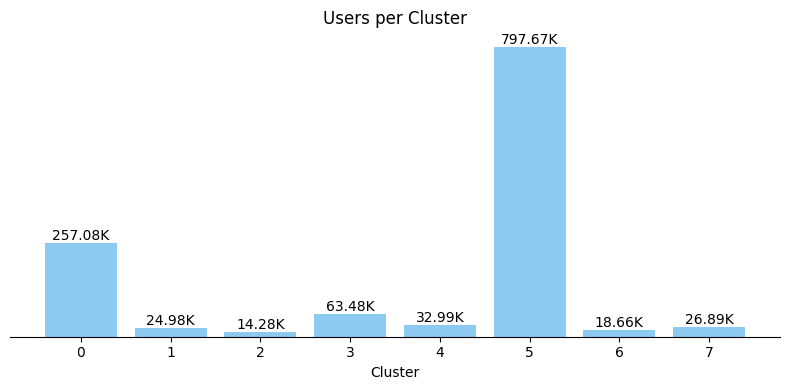

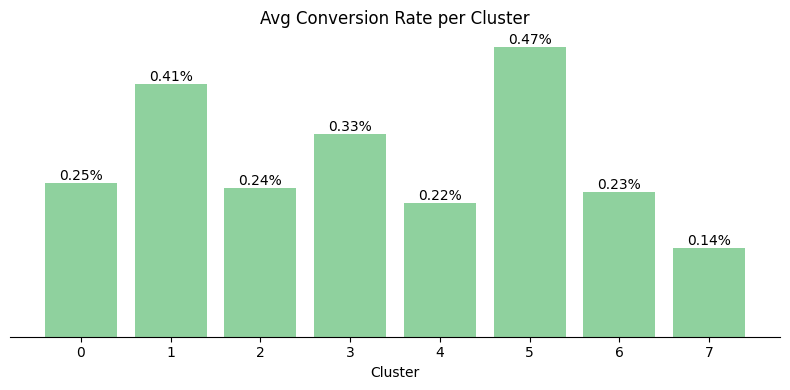

In [18]:

import numpy as np
import matplotlib.pyplot as plt

def fmt_compact(n: float) -> str:
    """1234 -> 1.23K; 1234567 -> 1.23M; otherwise int."""
    n = float(n)
    a = abs(n)
    if a >= 1_000_000:  return f"{n/1_000_000:.2f}M"
    if a >= 1_000:      return f"{n/1_000:.2f}K"
    return f"{int(n)}"

def plot_bar_no_y(x_labels, values, title, xlabel="", fmt_fn=str, color="#8EC9F0", figsize=(7,4)):
    fig, ax = plt.subplots(figsize=figsize)
    bars = ax.bar(x_labels, values, color=color, edgecolor="none")
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    # remove y-axis
    ax.set_yticks([])
    for spine in ("top","right","left"):
        ax.spines[spine].set_visible(False)
    ax.grid(False)

    # data labels
    for bar, v in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2,
                bar.get_height(),
                fmt_fn(v),
                ha="center", va="bottom", fontsize=10)
    plt.tight_layout()
    plt.show()

# ---- Use with your cluster_summary ----
# 1) Users per cluster
plot_bar_no_y(
    x_labels=cluster_summary["cluster"].astype(str),
    values=cluster_summary["users"].values,
    title="Users per Cluster",
    xlabel="Cluster",
    fmt_fn=fmt_compact,
    color="#8EC9F0",
    figsize=(8,4)
)

# (Optional) 2) Avg conversion rate (%) per cluster
if "conv_rate" in cluster_summary.columns:
    plot_bar_no_y(
        x_labels=cluster_summary["cluster"].astype(str),
        values=(cluster_summary["conv_rate"] * 100.0).values,
        title="Avg Conversion Rate per Cluster",
        xlabel="Cluster",
        fmt_fn=lambda v: f"{v:.2f}%",
        color="#8FD19E",
        figsize=(8,4)
    )


## Key Insights
Largest & Highest-Intent Cohort

Cluster 5 is the biggest group (~797.7K users) and shows the highest conversion rate ~0.47%.

This cohort concentrates a large share of purchasing and should be the primary target for personalization and monetization.

Additional High-Intent Cohort

Cluster 1 is smaller (~25.0K users) but strong with ~0.41% conversion—high purchase propensity despite size.

Mid-Tier Converters

Clusters 3 (~63.5K, ~0.33%), 0 (~257.1K, ~0.25%), 2 (~14.3K, ~0.24%), 6 (~18.7K, ~0.23%), and 4 (~33.0K, ~0.22%) show moderate purchase intent.

C0 is large but only mid-performing, suggesting room for improvement via relevance and nudges.

Lowest-Intent Cohort

Cluster 7 (~26.9K) has the lowest conversion ~0.14%, indicating “window shoppers” who need re-engagement or lower-friction offers.

## Business Implications & Limitations 

**Business implications (what the current models enable)**

1. Lift conversions with low latency:
Item-Cosine (BM25) gives the best offline scores among tested models. It’s fast (sparse dot-products + caching), so we can safely use it for real-time or near-real-time product carousels.

2. Stronger intent capture vs popularity:
Co-visitation/cosine explicitly recommends items often co-viewed/co-purchased together, which typically lifts add-to-cart and basket size compared to “Top sellers”.

3. Merchandising levers via reranking:
The hybrid reranker (base similarity + popularity, freshness, category conversion rate, user-category affinity) lets business teams tune trade-offs (growth of new items, margin, category pushes) without retraining.

4. Audience strategy:
The user clusters reveal segments (e.g., high-conversion “decisive” users vs casual browsers). You can target CRM journeys, homepage slots, and promo mixes per cluster.



**Limitations (why scores aren’t higher yet)**

1. Implicit-only signals & label noise:
We treat views/transactions as preferences; no explicit ratings, possible bot/accidental views, and non-purchase reasons (stockouts, price shocks) dilute signal.

2. Sparsity & cold-start:
Many users/items have few interactions; brand/price/text features were limited, so unseen items/users fall back to popularity or category heuristics.

3. Short context / no sequences:
Current models don’t leverage session order (e.g., last N clicks). You’ll miss short-term intent spikes captured by sequential models.

4. Popularity bias:
Similarity and reranking still reward already-popular items; without explicit diversity/coverage constraints, long-tail exposure can regress.
